In [1]:
# FEED ME SEVERAL GENESIS OUTPUT FILES

%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '/sdf/home/j/jytang/beamphysics/genesis/CBXFEL')
sys.path.insert(0, '/sdf/home/j/jytang/beamphysics/genesis/CBXFEL/genesis_interface')
sys.path.insert(0, '/sdf/home/j/jytang/beamphysics/genesis/CBXFEL/cavity_codes')

import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
import matplotlib
import numpy as np
import scipy.integrate as sint
import scipy.optimize as sopt
from scipy.interpolate import interp1d
import scipy.special as sspec
import pandas as pd
import itertools
from multiprocessing import Pool
from shutil import copyfile
from IPython import display
from numba import jit
import os, sys
from stats import *
from matplotlib.ticker import FormatStrFormatter
import genesis, parsers, lattice, analysis, lattice_operations, bsub, writers, wakefields#, interactive
import pickle
from scipy.optimize import curve_fit
import tftb
import scipy.signal as sig
from scipy.signal import savgol_filter


font = {#'family' : 'helvetica',
        #'weight' : 'bold',
        'size'   : 14}
matplotlib.rc('font', **font)

colorlist=['#f3ffa0', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']

from PIL import Image

In [39]:
def get_powers(z,record):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    s = np.array(zg.slice) * g.input['xlamds'] / 3e8 * g.input['zsep']
    return s,np.array(zg.power)

def plot_peak_powers_vs_z(color='C2',xlim=None,ylim=None,statfcn=[fwhm,mwhm,rms][0],merge_plots=False):
    pows_vs_z = []
    for z in zlist:
        pows_at_z = []
        for rec in records:
            sl,pl = get_powers(z,rec)
            pows_at_z += [np.max(pl)]
        pows_vs_z += [pows_at_z]
    pows_vs_z = np.transpose(pows_vs_z)*1e-9
    count  = 0
    for p in pows_vs_z:
        count += 1
        plt.plot(zlist,p,label = filenames[count-1].split('/')[-1])
    #plt.plot(zlist,mp,color=color,label='Power (GW)')
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    plt.xlabel('Position (m)')
    plt.ylabel('Power(GW)')
    plt.yscale('log')
    #plt.legend(fontsize = 10)
    plt.tight_layout()
   
    return zlist, pows_vs_z



In [40]:
def get_field(z, record):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    dt = g.input['xlamds'] / 3e8 * g.input['zsep']
    temp = np.array(zg.slice)
    sep = temp[1] - temp[0]
    s = np.array(zg.slice) * dt
    pmid = np.array(zg.p_mid); phimid = np.array(zg.phi_mid)
    field = np.sqrt(pmid) * np.exp(1j * phimid)
    
    return s, field

def get_spectra(z, record,  npad = 80000, cut = False, n_cut = 2):
    iz = np.argmin(np.abs(record['zlist']-z))
    rz = record['zlist'][iz]
    zg = record['zgroups'].get_group(rz)
    dt = g.input['xlamds'] / 299792458 * g.input['zsep']
    temp = np.array(zg.slice)
    sep = temp[1] - temp[0]
    s = np.array(zg.slice) * dt
    pmid = np.array(zg.p_mid); phimid = np.array(zg.phi_mid)
    s_fs = s*1e15
    
    s2 = np.arange(s.shape[0] + 2*npad) * dt*sep
    s_fs2 = s2*1e15
    
    if cut:
        pmid_s = savgol_filter(pmid, 51, 3)
        fwhm_ind = fwhm(pmid_s)
        arg_peak = np.argmax(pmid_s)
        print(arg_peak)
        print(fwhm_ind)
        s_cut = s[(arg_peak - int(n_cut*fwhm_ind//2)):(arg_peak + int(n_cut*fwhm_ind//2))]
        
        s2 = np.arange(s_cut.shape[0] + 2*npad) * dt*sep
        s_fs2 = s2*1e15
        
        #plt.figure()
        #plt.plot(s_cut, pmid[(arg_peak - int(n_cut*fwhm_ind//2)):(arg_peak + int(n_cut*fwhm_ind//2))], color = 'k', linewidth = 2)
        #plt.plot(s, pmid, alpha = 0.5)
        #plt.show()
    
    h_Plank = 4.135667696e-15
    c_speed  = 299792458
   
    ws = np.arange(s_fs2.shape[0]) / (s_fs2[-1] - s_fs2[0])
    ws -= np.mean(ws)
    hw0 = h_Plank * c_speed/g.input['xlamds']
    hws = h_Plank*1e15 * ws + hw0
    
    field = np.sqrt(pmid) * np.exp(1j * phimid) # units sqrt(GW/um^2)
    
    
    if cut:
        field_cut = field[(arg_peak - int(n_cut*fwhm_ind//2)):(arg_peak + int(n_cut*fwhm_ind//2))]
        field = np.pad(field_cut, (npad, npad))
        ftfld = np.fft.fftshift(np.fft.fft(field))
        spectra = np.abs(ftfld)**2
        
        
    
    else:
        field = np.pad(field, (npad, npad))
        ftfld = np.fft.fftshift(np.fft.fft(field))
        spectra = np.abs(ftfld)**2
    
   
    
    return hw0, hws, spectra

def Gauss(x, mu, sigma):
    y = np.exp(-(x-mu)**2/2/sigma**2)
    return y

## Read Genesis Output

In [44]:
folder_name = '../data_short_stats/'
filenames = []
#chirplist = np.linspace(0, 50, 11)
#for i in chirplist:
#    file_name = 'tap0.0_K1.172_x'+str(int(i))+'.out'
#    filenames.append(folder_name + file_name)
file_name1 = 'tap0.006_K1.172_n7.out'
file_name2 = 'tap0.006_K1.172_n8.out'
file_name3 = 'tap0.006_K1.172_n9.out'
labels = ['n7', 'n8', 'n9']
filenames = [folder_name + file_name1, folder_name + file_name2, folder_name + file_name3]
showPlotQ = True
records = []
for filename in filenames:
    record = {}

    basedir = '/'.join(filename.split('/')[:-1])
    workdir = basedir
    genoutfn = filename.split('/')[-1]
    fnhead = '.'.join(filename.split('/')[-1].split('.')[:-1])
    print('filename = ', filename)
    print('basedir = ', basedir)
    print('workdir = ', workdir)
    print('genoutfn = ', genoutfn)
    print('fnhead = ', fnhead)
    #break_code_xngdhgdjgdfj
    
    record['fnhead'] = fnhead
    record['genoutfn'] = genoutfn
    record['basedir'] = basedir
    record['workdir'] = workdir

    ## paths
    #basedir = '/gpfs/slac/staas/fs1/g/g.beamphysics/jduris'
    ##workdir = basedir+'/lh_shaping/LH_package_LCLSII_sc/elegant/scan_lower_edge_slopedwall/t0_-1_sigt_7_a0_0_a1_1_a2_1.5_a3_1_a4_10_l1p_-19.2_c1p_-148.97_l2p_-22.754_l3p_0.71_bc1_1_bc2_1.0201'#/genesis_charge_43pct_too_high'
    ##workdir += '/genesis_wcoefz_13.1_0.018_2'
    ##workdir += '/genesis_wcoefz_13.1_0.03_2'
    ##workdir += '/genesis_wcoefz_13.1_0.04_2'
    ##workdir += '/genesis_wcoefz_13.1_0.05_2'
    ##workdir += '/genesis_wcoefz_13.1_0.06_2'
    ##workdir += '/genesis_wcoefz_13.1_0.07_2' # best?
    ##workdir += '/genesis_wcoefz_13.1_0.08_2'
    ##workdir += '/genesis_wcoefz_20.25_0.018_2'
    ##workdir += '/genesis_wcoefz_20.25_0.03_2'
    #workdir = '/nfs/slac/g/beamphysics/jduris/lh_shaping/LH_package_LCLSII_sc/elegant/scan_sloped_wall_flatbeam_700A/t0_-1_dt_601793005265.1469_sigt_2_A_0_B_0_l1p_-19.2_c1p_-148.97_l2p_-20.754_l3p_0.71_bc1_1_bc2_1'
    ##fnhead = 'genesis'
    #fnhead = 'gen_tap_0.0001'
    ##fnhead = 'genesismp'
    savefolder = workdir

    # Setup generic genesis class
    params = {'workdir' : workdir,
            'genesis_bin' : 'genesis_BULLET',
            'input_file' : workdir + '/' + fnhead + '.in',
            'use_tempdir' : False}
    g = genesis.Genesis(**params)
    
    record['params'] = params
    record['g'] = g

    # Load Genesis output data
    g.load_output() # parse output
    zlist = np.asarray(g.output['lattice']['z'])
    slicedat = g.output['slice_data']
    #slist = np.array([sd['index'] for sd in slicedat]) * g.input['xlamds'] / 3e8
    slist = np.array([sd['index'] for sd in slicedat]) * g.input['xlamds'] / 3e8 * g.input['zsep']
    #slist = np.array([sd['index'] for sd in slicedat]) * g.input['xlamds'] * g.input['zsep'] * g.input['ishsty'] / 3e8
    slist_fs = slist * 1e15
    outputdat=[];
    for ii in range(len(slicedat)):
        if np.mod(ii,150)==0: print(ii);
        temp = pd.DataFrame.from_dict(slicedat[ii]['data'])
        temp.insert(0, 'slice', slicedat[ii]['index'])
        temp.insert(0, 'current', slicedat[ii]['current'])
        temp.insert(0, 'z', zlist)
        outputdat.append(temp)
    outputdat = pd.concat(outputdat, axis = 0)
    display.clear_output(wait = True)
    print(outputdat.head())
    currlist = outputdat['current'].iloc[::len(zlist)]
    energylist_init = outputdat['energy'].iloc[::len(zlist)]
    energylist_fin = outputdat['energy'].iloc[len(zlist)-1::len(zlist)]
    
    record['zlist'] = zlist
    record['slicedat'] = slicedat
    record['awlist'] = np.asarray(g.output['lattice']['aw'])
    record['qflist'] = np.asarray(g.output['lattice']['qfld'])
    record['slist'] = slist
    record['slist_fs'] = slist_fs
    record['outputdat'] = outputdat
    record['currlist'] = currlist
    record['energylist_init'] = energylist_init
    record['energylist_fin'] = energylist_fin

    # print pulse energy
    zgroups = outputdat.groupby('z')
    slicegroups = outputdat.groupby('slice');
    pulse_energy = zgroups.agg({'power':'sum'})['power'] * g.input['xlamds'] * g.input['zsep'] * g.input['ishsty'] / 3e8
    print('Peak output power: {:2.2f} GW'.format(outputdat['power'].max() * 1e-9))
    print('Pulse energy from sum of output power: {:2.2f} uJ'.format(pulse_energy.values[-1] * 1e6))
    print('Peak current:', outputdat['current'].max()*1e-3, 'kA')
    print('Average current:', outputdat['current'].mean()*1e-3, 'kA')
    
    record['zgroups'] = zgroups
    record['slicegroups'] = slicegroups
    record['pulse_energy'] = pulse_energy
    
    records += [record]




      z  current  slice        power     increment       p_mid  phi_mid  \
0  0.00    277.3      5  479530000.0  0.000000e+00  10116000.0  -1.2881   
1  0.26    277.3      5  479530000.0  1.836100e-13  10170000.0  -1.2987   
2  0.52    277.3      5  479640000.0  4.764500e-03  10236000.0  -1.3091   
3  0.78    277.3      5  479760000.0  4.634200e-03  10303000.0  -1.3195   
4  1.04    277.3      5  479860000.0  3.815400e-03  10369000.0  -1.3298   

     r_size  energy  bunching  ...  4th_far_fie  4th_bun_pha  4th_ff_phas  \
0  0.000026 -26.263  0.002634  ...          0.0          0.0          0.0   
1  0.000026 -26.263  0.002723  ...          0.0          0.0          0.0   
2  0.000026 -26.264  0.003020  ...          0.0          0.0          0.0   
3  0.000026 -26.265  0.003985  ...          0.0          0.0          0.0   
4  0.000026 -26.266  0.005920  ...          0.0          0.0          0.0   

   5th_bunchin  5th_power  5th_phase  5th_p-mid  5th_far_fie  5th_bun_pha  \
0        

## Plot Gain Curve

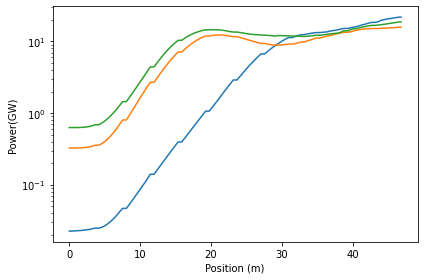

In [45]:
zlist, pows_vs_z = plot_peak_powers_vs_z()

## Power Profile

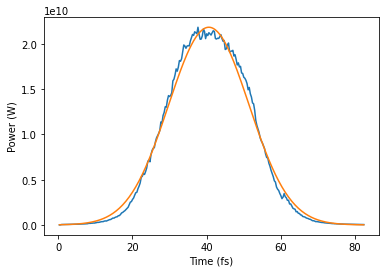

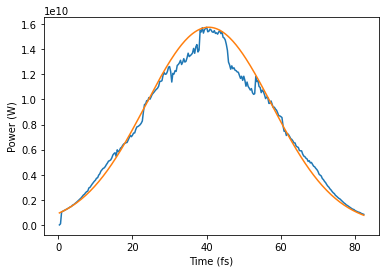

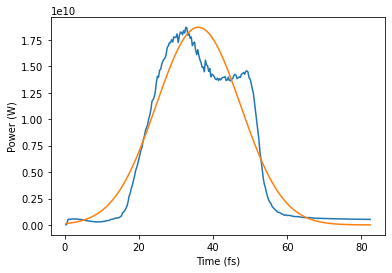

In [38]:
z  = np.max(records[0]['zlist'])
fwhm_list = []
count = 0
for record in records:
    sl,pl = get_powers(z,record)
    sl *=1e15
    ds = np.mean(np.diff(sl))
    
    #Gaussian fitting
    sl_fit = sl #sl - sl[np.argmax(pl)]
    pl_fit = pl/np.max(pl)
    parameters, covariance = curve_fit(Gauss, sl_fit, pl_fit,p0 = [50, 20])
    pl_gauss = Gauss(sl_fit, parameters[0], parameters[1])
    pl_gauss *= np.max(pl)
    
    plt.figure()
    plt.plot(sl, pl, label = str(np.round(chirplist[count]/60, 2)) + 'MeV/fs')
    plt.plot(sl, pl_gauss,label = 'Gaussian fitting')
    plt.xlabel('Time (fs)')
    plt.ylabel('Power (W)')
    plt.show()
    
    sfwhm = fwhm(pl)* ds
    #fwhm_list.append(sfwhm)
    fwhm_list.append(parameters[1]*2*np.sqrt(2*np.log(2)))
    count += 1
#plt.legend()
plt.show()
    
#plt.figure()
#plt.plot(chirplist, fwhm_list, 'o-')
#plt.xlabel('ebeam chirp (MeV/60fs)')
#plt.ylabel('FWHM pulse duration(fs)' )

In [35]:
pickle.dump((sl,pl), open( "S2E_power.p", "wb" ) )


## On axis Spectrum

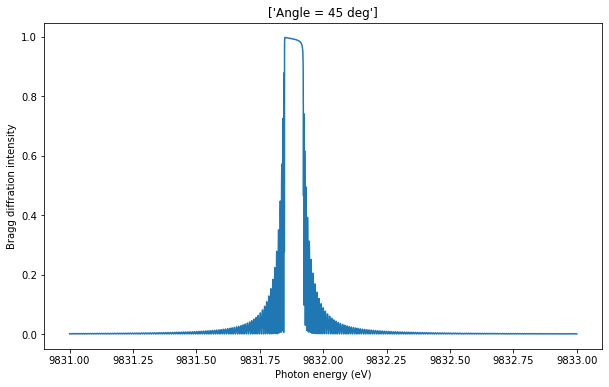

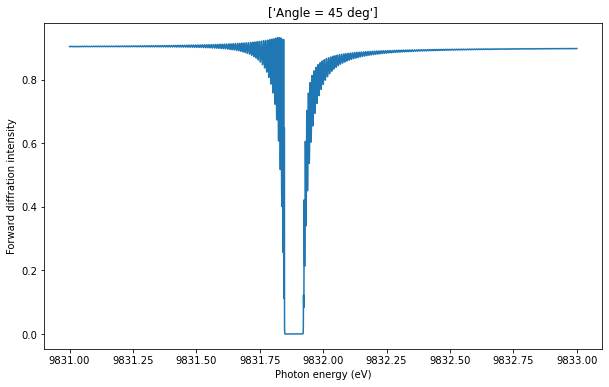

In [48]:
from cavity_codes.Bragg_mirror import *
Eph, R0H, R00 = plot_Bragg_mirror_response_slice(d = 100e-6)

"   \nplt.figure()\nplt.plot(chirplist, spec_fwhm_list, 'o-')\nplt.plot(chirplist, flim_bw)\nplt.xlabel('electron beam chirp (MeV/fs)')\nplt.ylabel('FWHM bandwidth (eV)')\nplt.figure()\nplt.plot(chirplist, flim,label = 'Fourier limit')\nplt.plot(chirplist, fwhm_list, label = 'Pulse width')\nplt.xlabel('electron beam chirp (MeV/fs)')\nplt.ylabel('FEL pulse duration FWHM(fs)')\nplt.legend()\n"

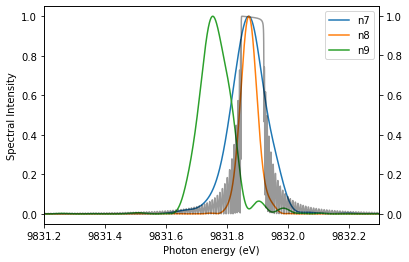

In [54]:
#z  = 15#np.max(records[0]['zlist'])
spec_fwhm_list = []
flim = []
low = 9831.2
high = 9832.3
count = 0
for record in records:
    hw0, sl,pl = get_spectra(z,record, cut = False, n_cut = 3)
    ds = np.mean(np.diff(sl))
    
    #Gaussian fitting
    
    pl = pl[(sl < high) & (sl > low)]
    sl = sl[(sl < high) & (sl > low)] 
    sl_fit = sl#sl - sl[np.argmax(pl)]
    pl_fit = pl/np.max(pl)
    parameters, covariance = curve_fit(Gauss, sl_fit, pl_fit,p0 = [hw0, 0.1])
    pl_gauss = Gauss(sl_fit, parameters[0], parameters[1])
    pl_gauss *= np.max(pl)
    
    #plt.figure()
    plt.plot(sl_fit, pl_fit, label = labels[count])
    #plt.plot(sl, pl_gauss, label = 'Gaussian fitting')
    plt.xlabel('Photon energy (eV)')
    plt.ylabel('Spectral Intensity')
    plt.xlim([low, high])
    #plt.show()
    sfwhm = fwhm(pl)* ds
    #spec_fwhm_list.append(sfwhm)
    spec_fwhm_list.append(parameters[1]*2*np.sqrt(2*np.log(2)))
    bw= 1.82495/sfwhm
    flim.append(bw)
    count += 1
plt.legend()
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(Eph, R0H, alpha = 0.4, color = 'k')

    
flim_bw = 1.82495/np.array(fwhm_list)
"""   
plt.figure()
plt.plot(chirplist, spec_fwhm_list, 'o-')
plt.plot(chirplist, flim_bw)
plt.xlabel('electron beam chirp (MeV/fs)')
plt.ylabel('FWHM bandwidth (eV)')
plt.figure()
plt.plot(chirplist, flim,label = 'Fourier limit')
plt.plot(chirplist, fwhm_list, label = 'Pulse width')
plt.xlabel('electron beam chirp (MeV/fs)')
plt.ylabel('FEL pulse duration FWHM(fs)')
plt.legend()
""" 

In [38]:
pickle.dump((sl,pl), open( "S2E_spectrum.p", "wb" ) )


In [71]:
pickle.dump((chirplist,fwhm_list), open( "fwhm_time.p", "wb" ) )
pickle.dump((chirplist,flim), open( "flim_time.p", "wb" ) )
pickle.dump((chirplist,spec_fwhm_list), open( "fwhm_spec.p", "wb" ) )
pickle.dump((chirplist,flim_bw), open( "flim_spec.p", "wb" ) )

## Test Wigner distribution

In [166]:
s, field = get_field(z = 20, record = records[0])

In [154]:
T = np.max(s) - np.min(s)  # signal duration
dt = np.mean(np.diff(s))  # sample interval/spacing
freq_s = 1/dt  # sampling frequency
N = s.shape[0]  # number of samples
ts = s  # times
signal = field

In [155]:
# first looking at the power of the short time fourier transform (SFTF):
nperseg = 128  # window size of the STFT
f_stft, t_stft, Zxx = sig.stft(signal, freq_s, nperseg=nperseg,
                           noverlap=nperseg-1, return_onesided=False)

# shifting the frequency axis for better representation
Zxx = np.fft.fftshift(Zxx, axes=0)
f_stft = np.fft.fftshift(f_stft)

# Doing the WVT
wvd = tftb.processing.WignerVilleDistribution(signal, timestamps=ts)
tfr_wvd, t_wvd, f_wvd = wvd.run()
# here t_wvd is the same as our ts, and f_wvd are t

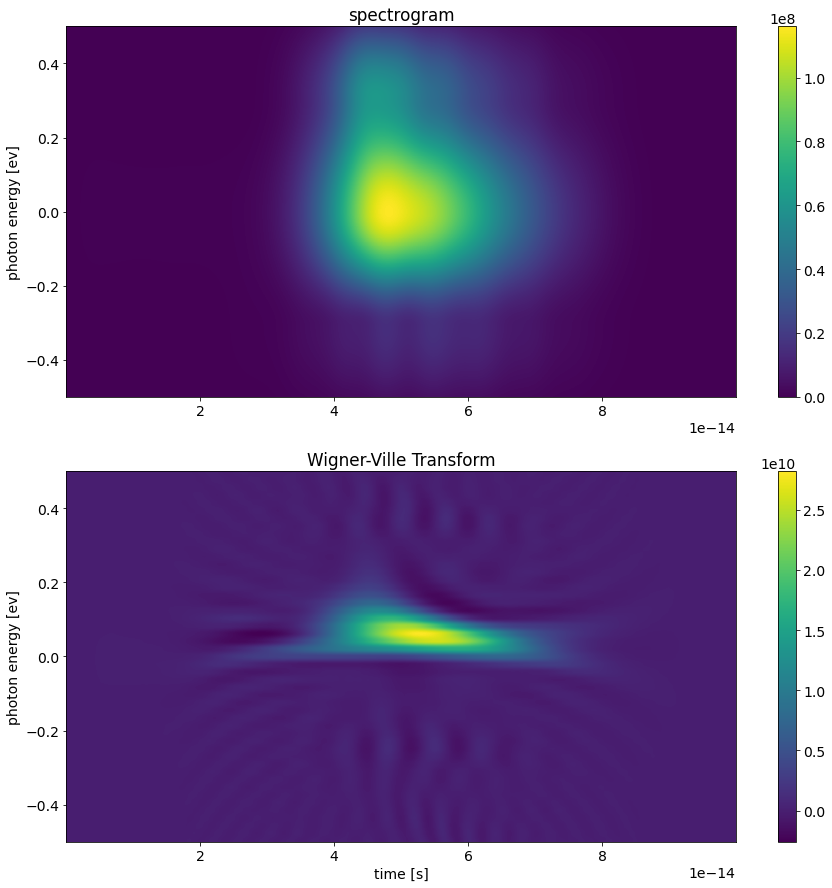

In [156]:
#Now plotting the heatmaps:

f, axx = plt.subplots(2, 1)
f.set_figheight(15)
f.set_figwidth(15)
f_stft = 2*np.pi*f_stft*6.582119569e-16
df1 = f_stft[1] - f_stft[0]  # the frequency step

im = axx[0].imshow(np.real(Zxx * np.conj(Zxx)), aspect='auto',
          interpolation=None, origin='lower',
          extent=(ts[0] - dt/2, ts[-1] + dt/2,
                  f_stft[0] - df1/2, f_stft[-1] + df1/2))
axx[0].set_ylabel('photon energy [ev]')
plt.colorbar(im, ax=axx[0])
axx[0].set_title('spectrogram')
axx[0].set_ylim([-0.5, 0.5])


# because of how they implemented WVT, the maximum frequency is half of
# the sampling Nyquist frequency, so 125 Hz instead of 250 Hz, and the sampling
# is 2 * dt instead of dt
f_wvd = np.fft.fftshift(np.fft.fftfreq(tfr_wvd.shape[0], d=2 * dt))
f_wvd = 2*np.pi*f_wvd*6.582119569e-16
df_wvd = f_wvd[1]-f_wvd[0]  # the frequency step in the WVT
im = axx[1].imshow(np.fft.fftshift(tfr_wvd, axes=0), aspect='auto', origin='lower',
       extent=(ts[0] - dt/2, ts[-1] + dt/2,
               f_wvd[0]-df_wvd/2, f_wvd[-1]+df_wvd/2))
axx[1].set_xlabel('time [s]')
axx[1].set_ylabel('photon energy [ev]')
axx[1].set_ylim([-0.5, 0.5])
plt.colorbar(im, ax=axx[1])
axx[1].set_title('Wigner-Ville Transform')
plt.show()

## Spectral Center shift

In [9]:
def plot_spectra_vs_z(rec = record, color='C2',xlim=None,ylim=None,title = None, statfcn=[fwhm,mwhm,rms][0],merge_plots=False):
    pows_vs_z = []
   
    
 
    for z in zlist:
        hw0, sl,pl = get_spectra(z,rec)     
        pows_vs_z.append((hw0, sl, pl))
    count  = 0
    for _, sl, pl in pows_vs_z[::10]:
        count += 1
        plt.plot(sl, pl)
        
    #plt.plot(zlist,mp,color=color,label='Power (GW)')
    if xlim != None: plt.xlim(xlim)
    if ylim != None: plt.ylim(ylim)
    plt.xlabel('s (m)')
    plt.ylabel('Spectral Intensity')
    #plt.yscale('log')
    #plt.legend(fontsize = 10)
    plt.tight_layout()
    if title:
        plt.title(title)
    plt.show()
   
    return zlist, pows_vs_z


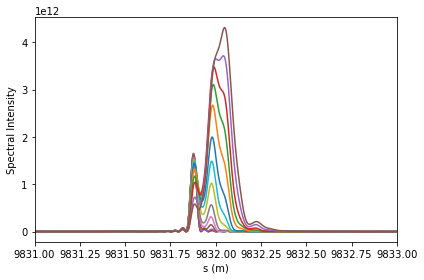

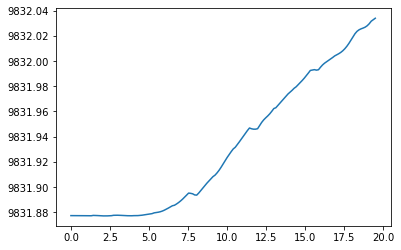

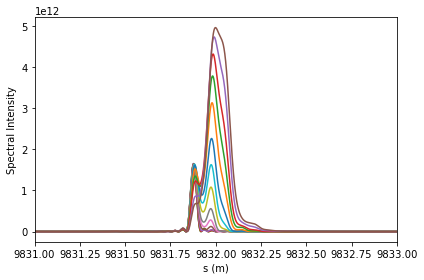

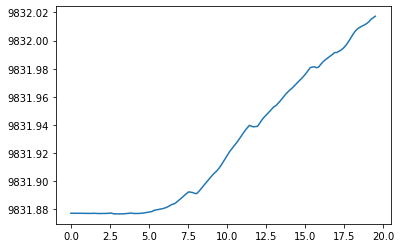

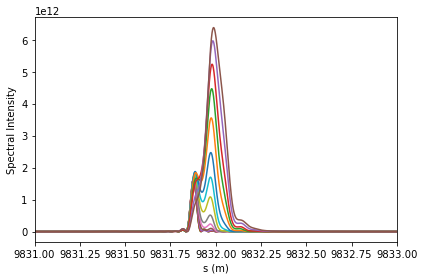

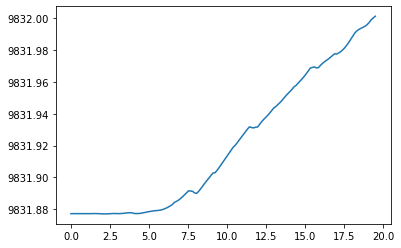

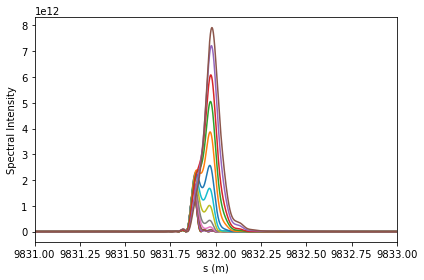

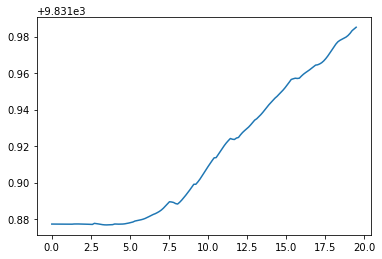

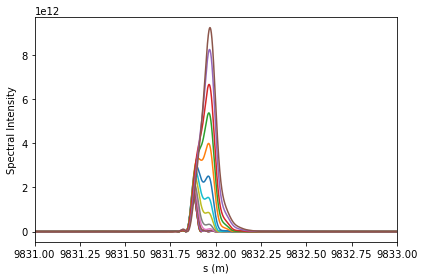

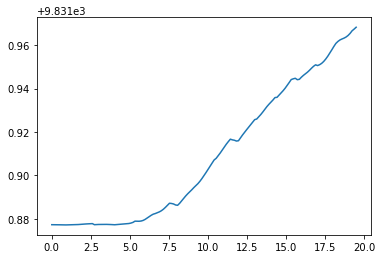

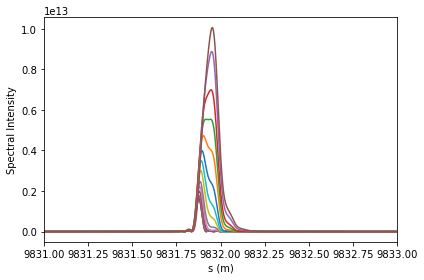

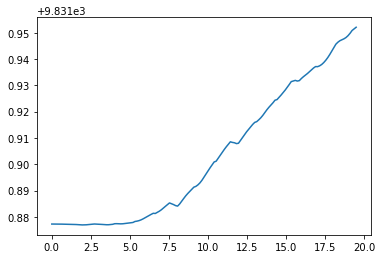

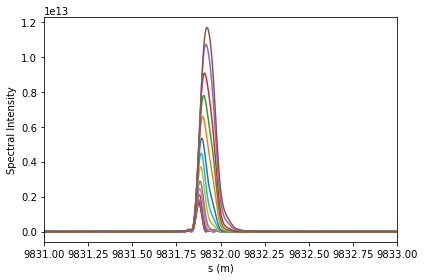

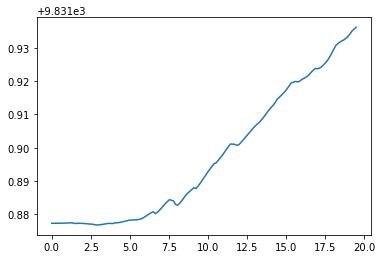

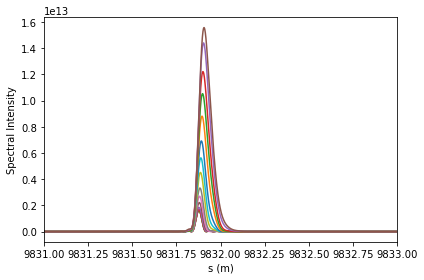

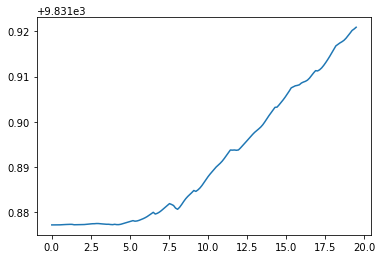

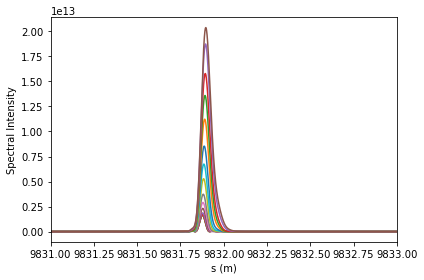

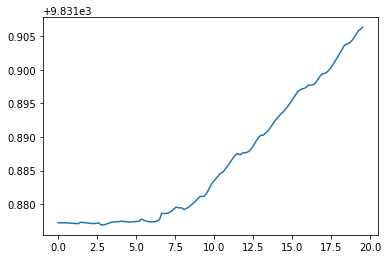

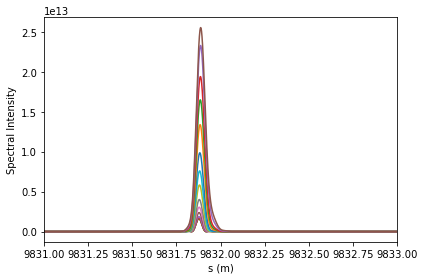

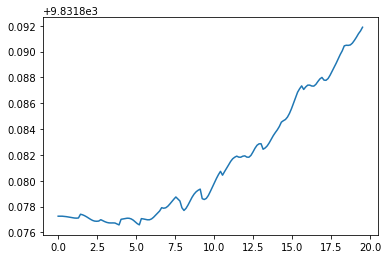

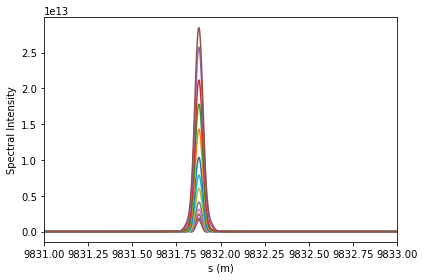

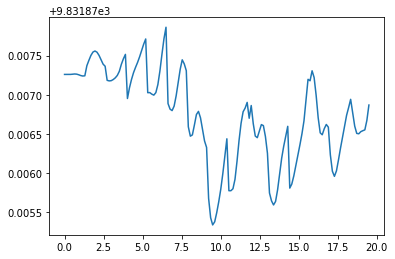

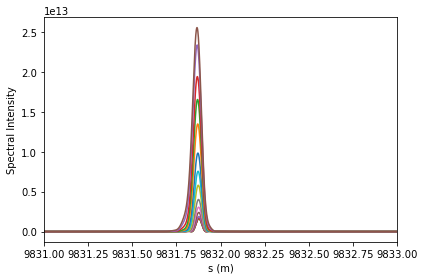

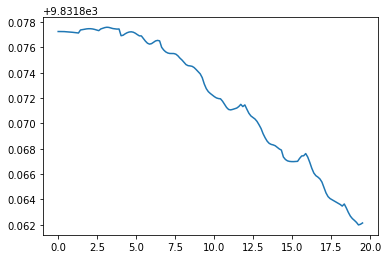

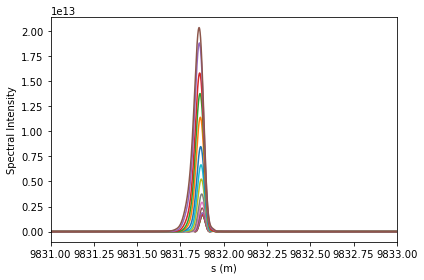

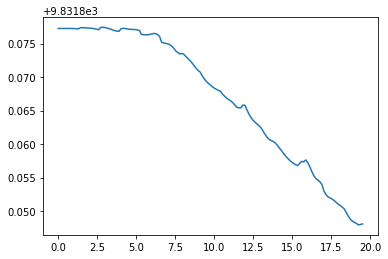

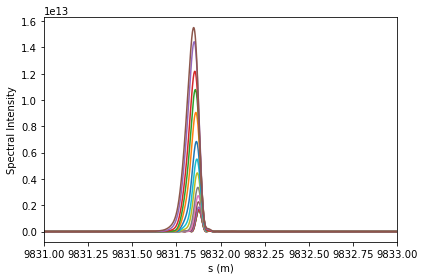

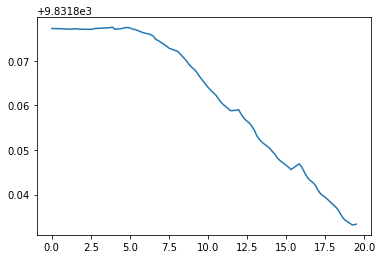

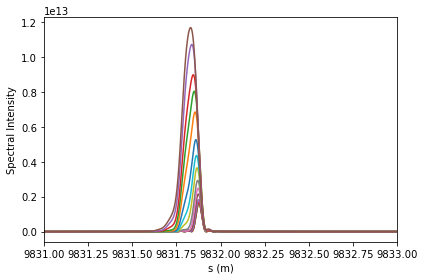

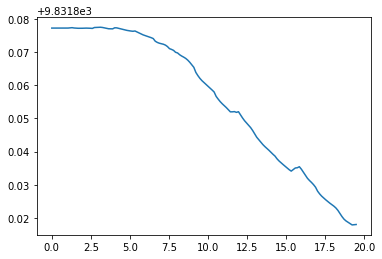

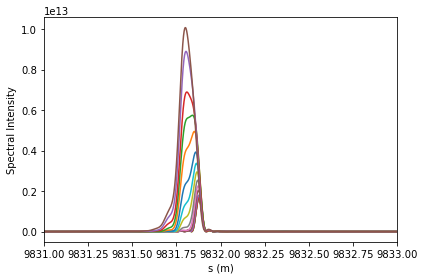

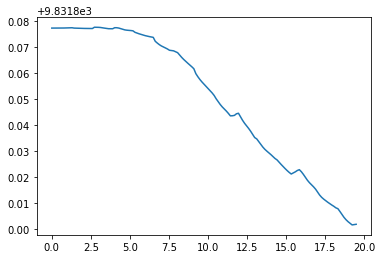

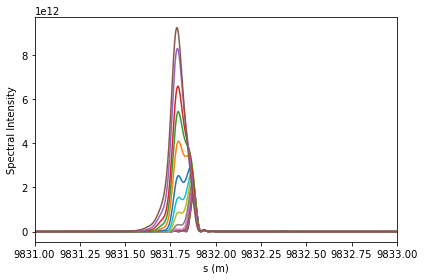

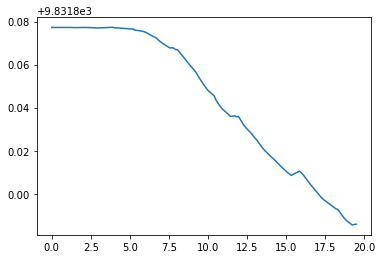

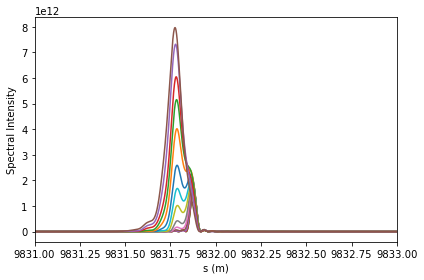

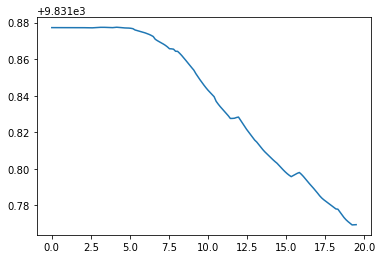

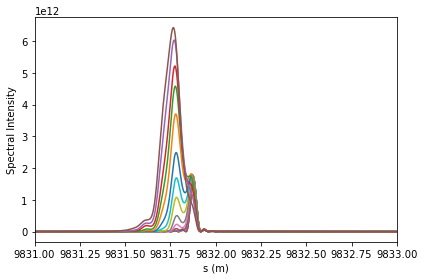

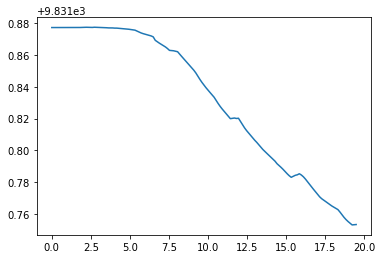

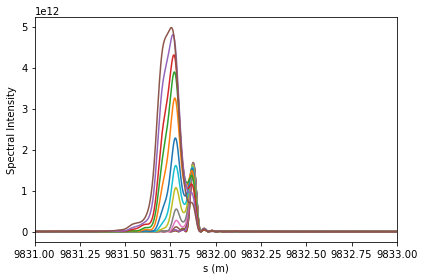

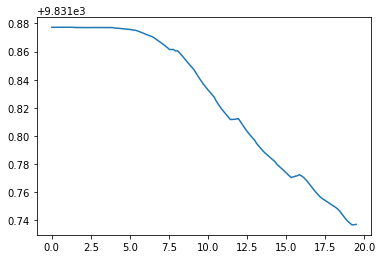

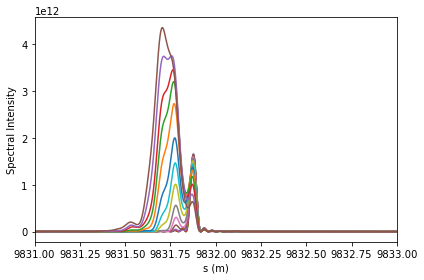

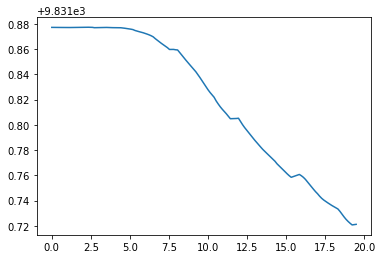

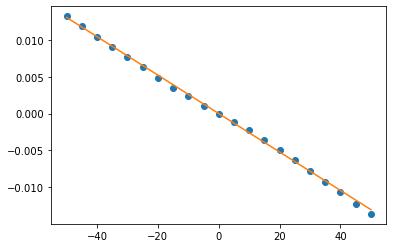

In [10]:

count = 0
chirp_rate_list = []
for rec in records:
    chirp = chirplist[count]
    zlist, pows_vs_z = plot_spectra_vs_z(rec = records[count], xlim = [9831, 9833])

    zlow = 3.9*2
    zhigh = 3.9*4
    scenter_list = []
    for count1 in range(len(zlist)):
        #z = zlist[count]
        hw0, sl, pl = pows_vs_z[count1]
        #scenter = sl[np.argmax(pl)]
        scenter = np.sum(sl*pl)/np.sum(pl)
        scenter_list.append(scenter)
    plt.figure(100)
    plt.plot(zlist, scenter_list)
    plt.show()

    zlist = np.array(zlist)
    scenter_list = np.array(scenter_list)

    zcut = zlist[(zlist>=zlow) &(zlist <=zhigh)]
    scut = scenter_list[(zlist>=zlow) &(zlist <=zhigh)]
    p = np.polyfit(zcut, scut, deg = 1)
    chirp_rate = p[0]
    chirp_rate_list.append(chirp_rate)
    count += 1

plt.figure()
plt.plot(chirplist, chirp_rate_list, 'o')
gamma = 8000/0.510998950;
cspeed = 299792458;
mc2 = 0.510998950;
K = 1.64;
dgam = chirplist/mc2;
dt = 100e-15;
lamda_r = 1.261043e-10;
kr = 2*np.pi/lamda_r;
d_omega = -(1+K**2/2)/(gamma**2)*dgam/gamma/dt*kr
h_plank =  6.582119569e-16
theory = d_omega*h_plank*2/3
plt.plot(chirplist, d_omega*h_plank*2/3)


In [11]:
pickle.dump((chirplist,theory), open( "centershift_theory.p", "wb" ) )
pickle.dump((chirplist,chirp_rate_list), open( "centershift_sim.p", "wb" ) )

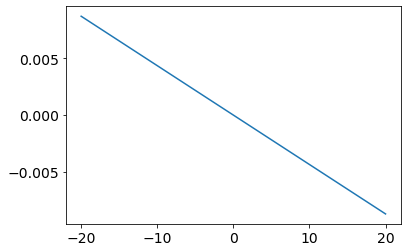

In [21]:
chirplist = np.linspace(-20, 20, 100)
gamma = 8000/0.510998950;
cspeed = 299792458;
mc2 = 0.510998950;
K = 1.64;
dgam = chirplist/mc2;
dt = 60e-15;
lamda_r = 1.261043e-10;
kr = 2*np.pi/lamda_r;
d_omega = -(1+K**2/2)/(gamma**2)*dgam/gamma/dt*kr
h_plank =  6.582119569e-16

plt.plot(chirplist, d_omega*h_plank*2/3)

In [23]:
from scipy.signal import savgol_filter, find_peaks

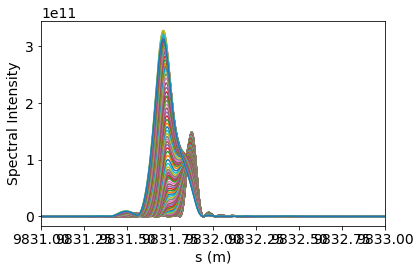

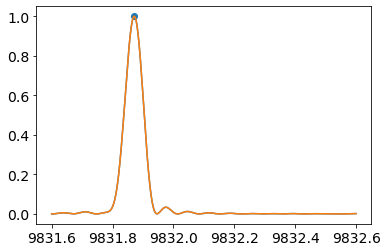

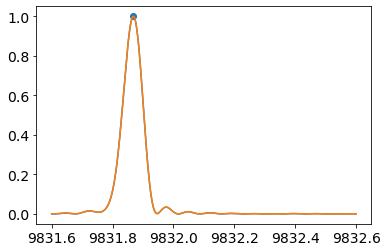

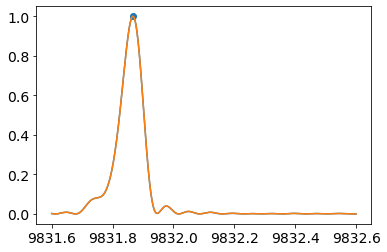

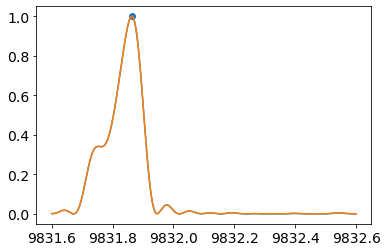

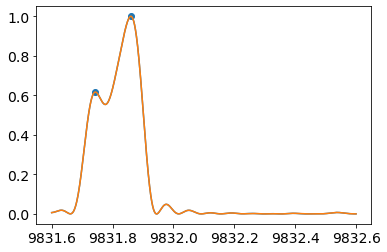

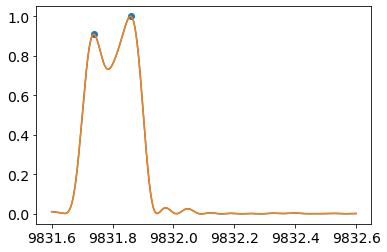

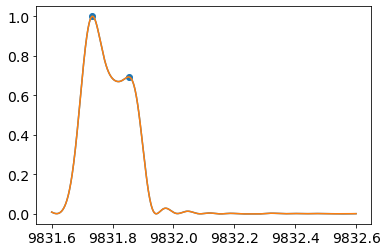

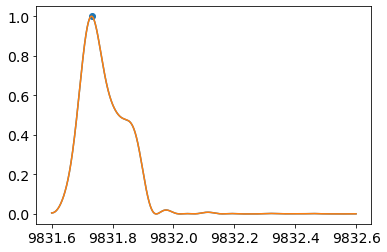

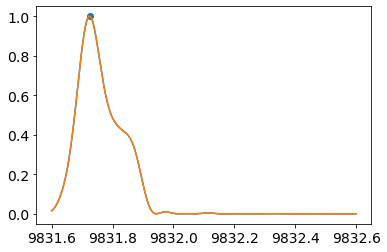

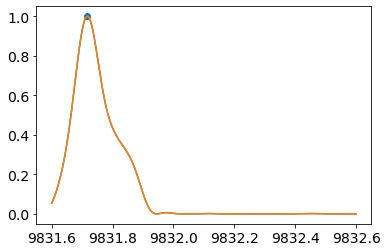

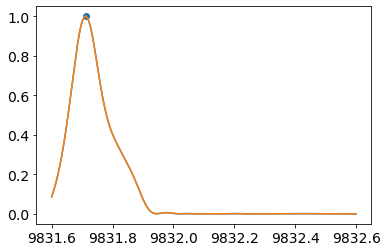

In [119]:
low = 9831.6
high = 9832.6
mu1 = 9831.875


zlist, pows_vs_z = plot_spectra_vs_z(rec = records[6], xlim = [9831, 9833])

for ind in np.linspace(50,150,11):
    hw0, sl, pl = pows_vs_z[int(ind)]
    sl2 = sl[(sl < high) & (sl > low)]
    pl = pl[(sl < high) & (sl > low)]
    pl/=np.max(pl)
    plt.plot(sl2, pl)

    smooth = savgol_filter(pl, window_length = 101, polyorder = 5)
    plt.plot(sl2, smooth)
    peaks, _ = find_peaks(smooth, height = 0.1, prominence=0.01)
    plt.scatter(sl2[peaks], smooth[peaks])
    plt.show()

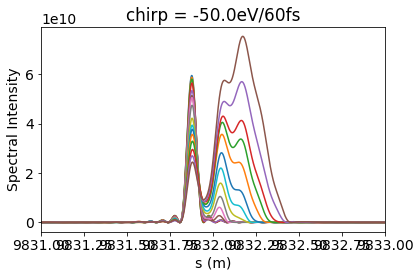

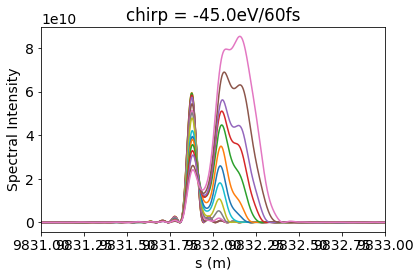

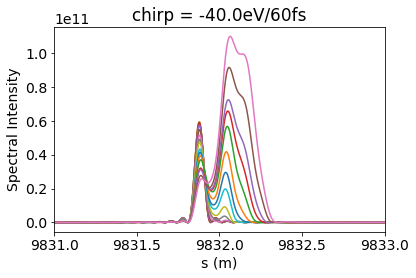

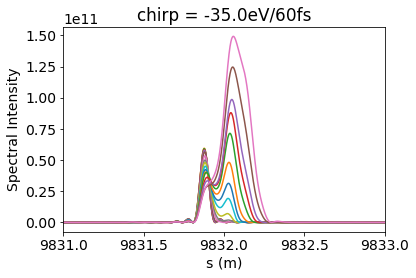

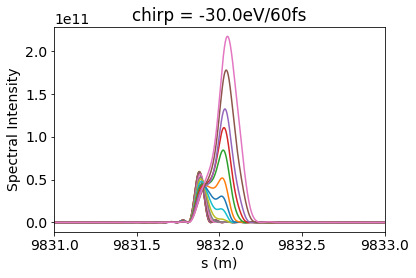

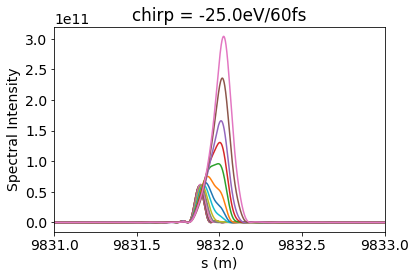

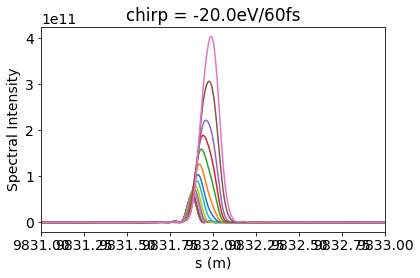

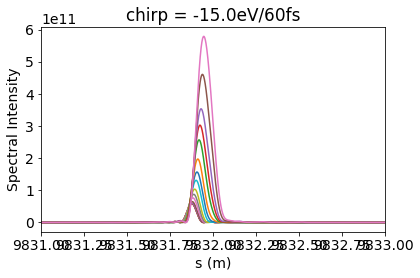

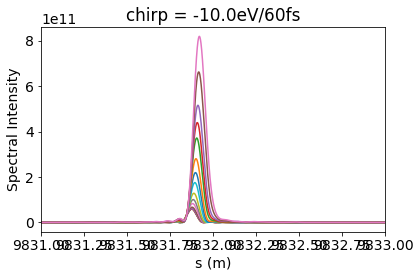

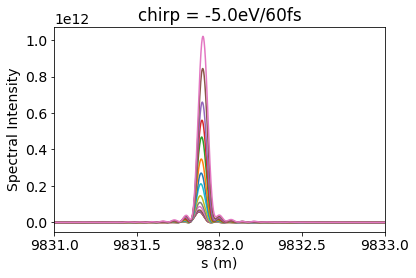

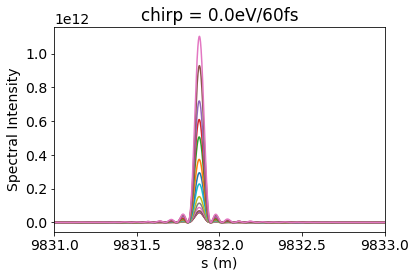

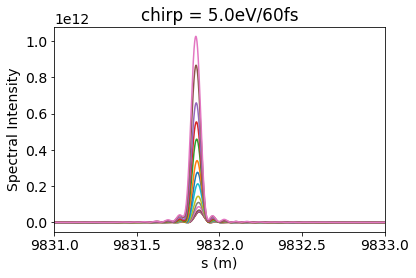

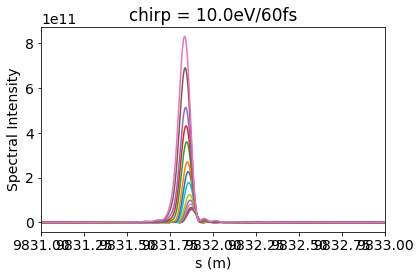

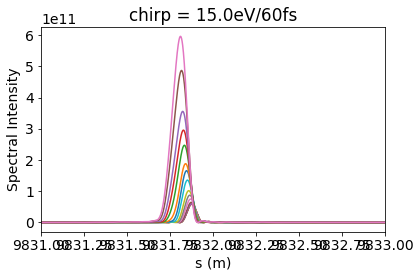

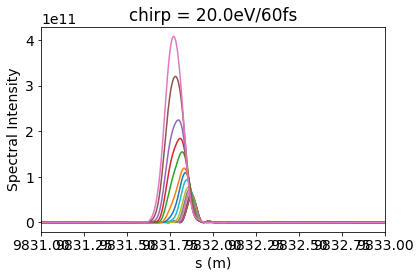

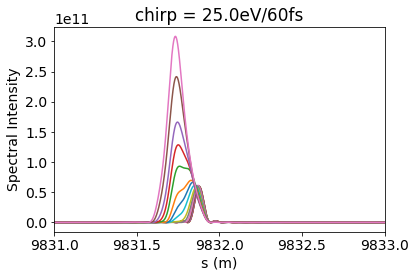

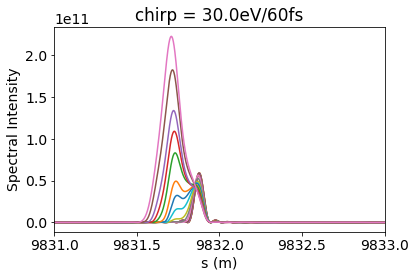

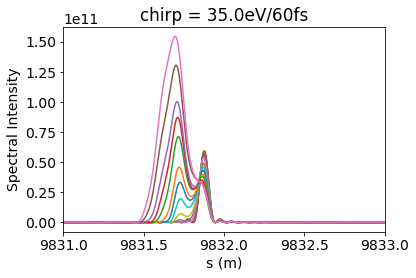

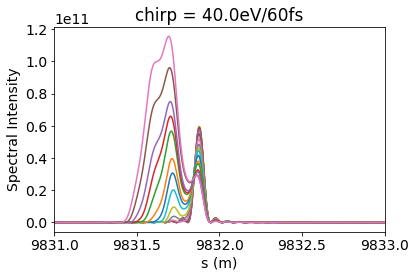

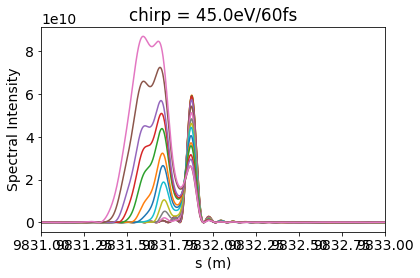

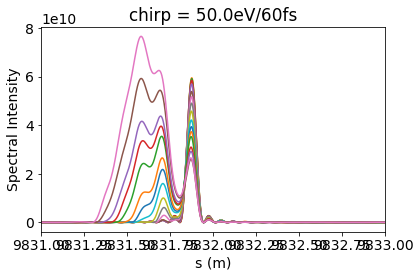

No handles with labels found to put in legend.


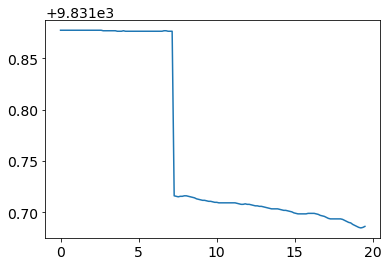

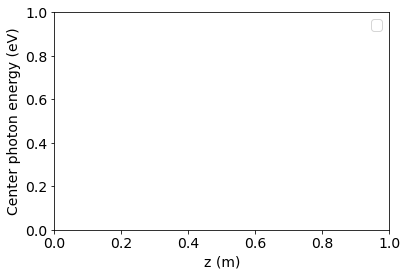

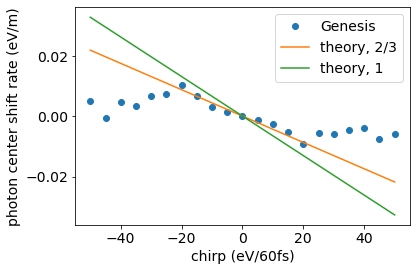

No handles with labels found to put in legend.


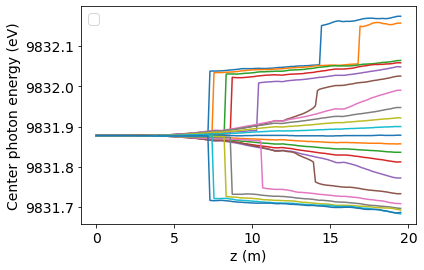

In [70]:
chirplist = np.linspace(-50, 50, 21)
count = 0
chirp_rate_list = []
plt.figure(100)
for rec in records:
    chirp = chirplist[count]
    zlist, pows_vs_z = plot_spectra_vs_z(rec = records[count], xlim = [9831, 9833], title = 'chirp = ' + str(chirp) + 'eV/60fs')

    zlow = 18
    zhigh = 20
    scenter_list = []

    for count1 in range(len(zlist)):
        #z = zlist[count]
        hw0, sl, pl = pows_vs_z[count1]
        low = 9831.6
        high = 9832.6
        sl2 = sl[(sl < high) & (sl > low)]
        pl = pl[(sl < high) & (sl > low)]
        pl/=np.max(pl)
        smooth = savgol_filter(pl, window_length = 21, polyorder = 5)
        peaks, _ = find_peaks(smooth, height = 0.1, prominence=0.01)
        
        if chirp < 0:
            scenter = sl2[peaks[-1]]
        else:
            scenter = sl2[peaks[0]]
        
        scenter_list.append(scenter)
    
    plt.plot(zlist, scenter_list, label = str(chirp) + 'eV/60fs')
    
    zlist = np.array(zlist)
    scenter_list = np.array(scenter_list)

    zcut = zlist[(zlist>=zlow) &(zlist <=zhigh)]
    scut = scenter_list[(zlist>=zlow) &(zlist <=zhigh)]
    p = np.polyfit(zcut, scut, deg = 1)
    chirp_rate = p[0]
    chirp_rate_list.append(chirp_rate)
    count += 1

plt.figure(100)
plt.legend()
plt.xlabel('z (m)')
plt.ylabel('Center photon energy (eV)')
plt.show()

plt.figure()
plt.plot(np.array(chirplist), chirp_rate_list, 'o', label = 'Genesis')



gamma = 8000/0.510998950;
cspeed = 299792458;
mc2 = 0.510998950;
K = 1.64;
dgam = chirplist/mc2;
dt = 60e-15;
lamda_r = 1.261043e-10;
kr = 2*np.pi/lamda_r;
d_omega = -(1+K**2/2)/(gamma**2)*dgam/gamma/dt*kr
h_plank =  6.582119569e-16

plt.plot(chirplist, d_omega*h_plank*2/3, label ='theory, 2/3')
plt.plot(chirplist, d_omega*h_plank, label ='theory, 1')
plt.legend()
plt.xlabel('chirp (eV/60fs)')
plt.ylabel('photon center shift rate (eV/m)')
plt.show()

plt.show()

count = 0
for rec in records:
    chirp = chirplist[count]
    scenter_list = []
    for z in zlist:
        hw0, sl,pl = get_spectra(z,rec) 
        low = 9831.6
        high = 9832.6
        sl2 = sl[(sl < high) & (sl > low)]
        pl = pl[(sl < high) & (sl > low)]
        pl/=np.max(pl)
        smooth = savgol_filter(pl, window_length = 21, polyorder = 5)
        peaks, _ = find_peaks(smooth, height = 0.1, prominence=0.01)
        
        if chirp < 0:
            scenter = sl2[peaks[-1]]
        else:
            scenter = sl2[peaks[0]]
        
        scenter_list.append(scenter)
    plt.plot(zlist, scenter_list)
    count += 1
plt.legend()
plt.xlabel('z (m)')
plt.ylabel('Center photon energy (eV)')
plt.show()

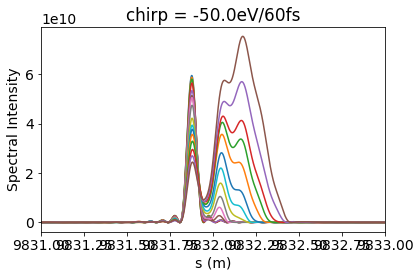

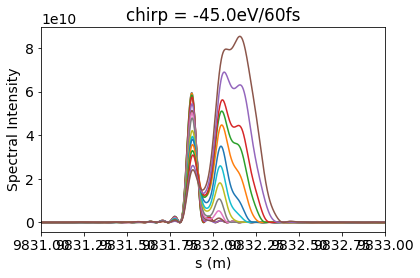

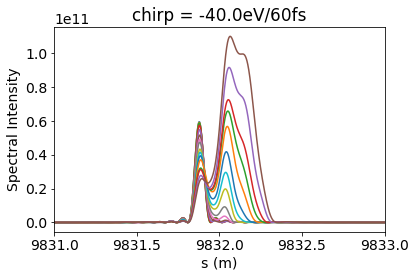

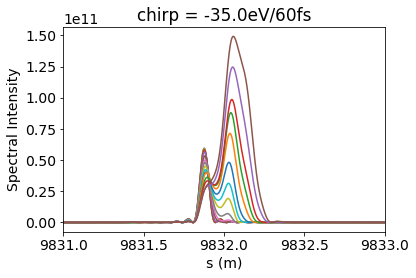

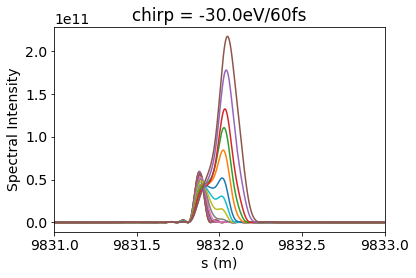

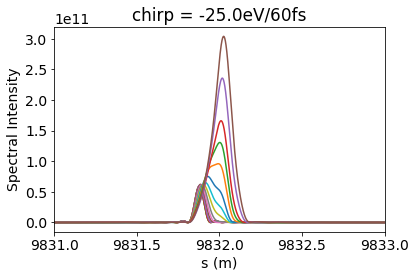

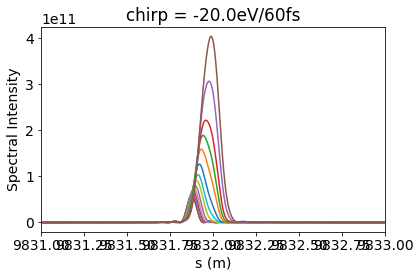

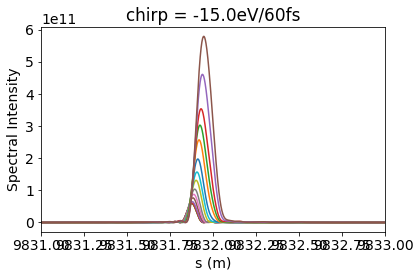

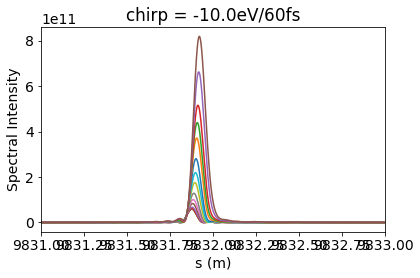

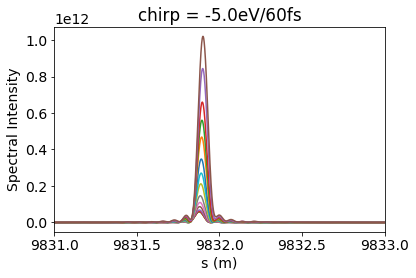

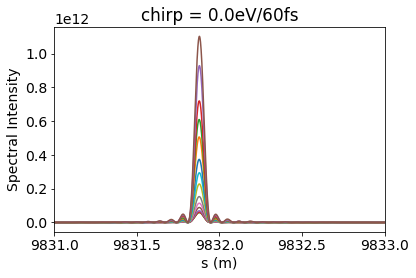

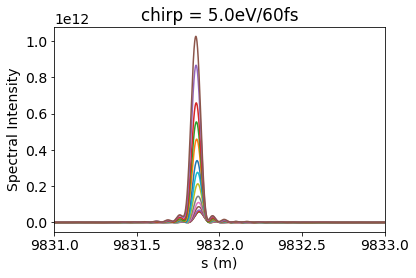

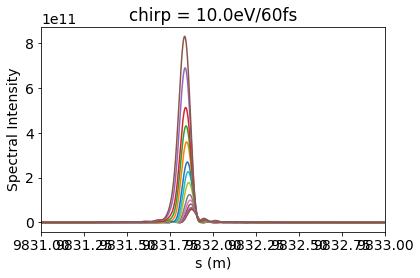

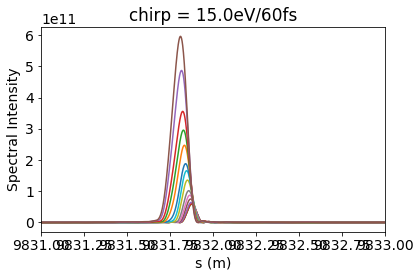

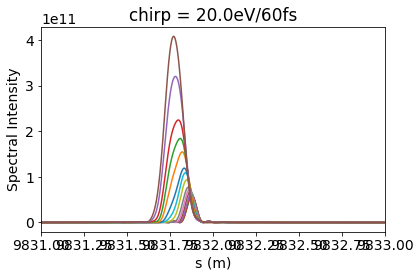

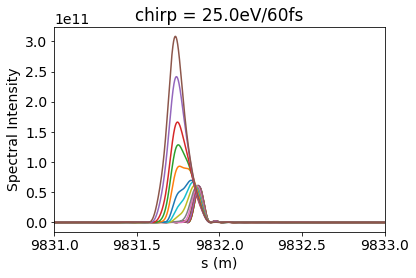

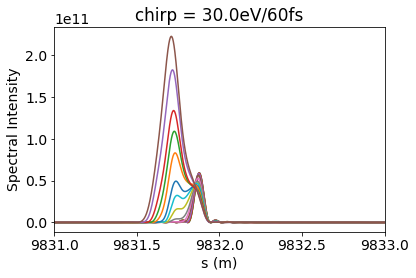

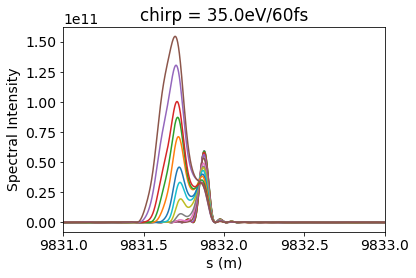

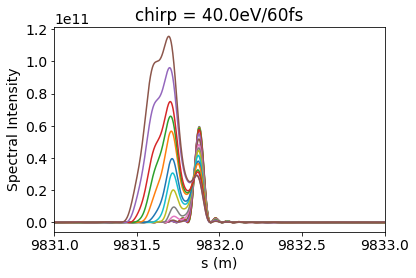

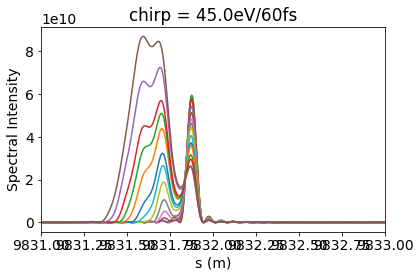

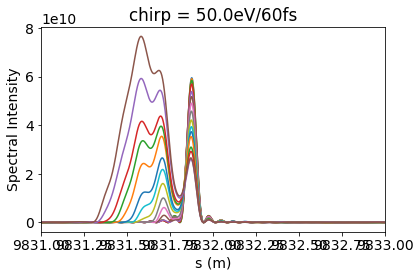

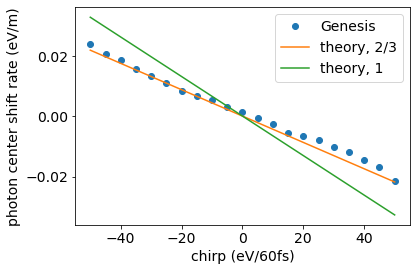

No handles with labels found to put in legend.


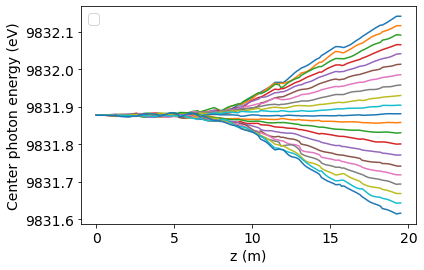

In [72]:
chirplist = np.linspace(-50, 50, 21)
count = 0
chirp_rate_list = []
plt.figure(100)
for rec in records:
    chirp = chirplist[count]
    zlist, pows_vs_z = plot_spectra_vs_z(rec = records[count], xlim = [9831, 9833], title = 'chirp = ' + str(chirp) + 'eV/60fs')

    zlow = 3.9*4
    zhigh = 3.9*5
    scenter_list = []

    for count1 in range(len(zlist)):
        #z = zlist[count]
        hw0, sl, pl = pows_vs_z[count1]
        low = 9831.6
        high = 9832.6
        #sl2 = sl[(sl < high) & (sl > low)]
        #pl = pl[(sl < high) & (sl > low)]
        #pl/=np.max(pl)
        sl2 = sl
        smooth = savgol_filter(pl, window_length = 21, polyorder = 5)
        #peaks, _ = find_peaks(smooth, height = 0.1, prominence=0.01)
        
        #if chirp < 0:
        #    scenter = sl2[peaks[-1]]
        #else:
        #    scenter = sl2[peaks[0]]
        
        scenter = np.sum(sl2*pl)/np.sum(pl)
        
        scenter_list.append(scenter)
        

    
    
    
    zlist = np.array(zlist)
    scenter_list = np.array(scenter_list)

    zcut = zlist[(zlist>=zlow) &(zlist <=zhigh)]
    scut = scenter_list[(zlist>=zlow) &(zlist <=zhigh)]
    p = np.polyfit(zcut, scut, deg = 1)
    chirp_rate = p[0]
    chirp_rate_list.append(chirp_rate)
    count += 1



plt.figure()
plt.plot(np.array(chirplist), chirp_rate_list, 'o', label = 'Genesis')



gamma = 8000/0.510998950;
cspeed = 299792458;
mc2 = 0.510998950;
K = 1.64;
dgam = chirplist/mc2;
dt = 60e-15;
lamda_r = 1.261043e-10;
kr = 2*np.pi/lamda_r;
d_omega = -(1+K**2/2)/(gamma**2)*dgam/gamma/dt*kr
h_plank =  6.582119569e-16

plt.plot(chirplist, d_omega*h_plank*2/3, label ='theory, 2/3')
plt.plot(chirplist, d_omega*h_plank, label ='theory, 1')
plt.legend()
plt.xlabel('chirp (eV/60fs)')
plt.ylabel('photon center shift rate (eV/m)')
plt.show()



In [ ]:
count = 0
for rec in records:
    chirp = chirplist[count]
    scenter_list = []
    for z in zlist:
        hw0, sl,pl = get_spectra(z,rec) 
        #low = 9831.6
        #high = 9832.6
        #sl2 = sl[(sl < high) & (sl > low)]
        #pl = pl[(sl < high) & (sl > low)]
        sl2 = sl
        pl/=np.max(pl)
        smooth = savgol_filter(pl, window_length = 21, polyorder = 5)
        
        scenter = np.sum(sl2*pl)/np.sum(pl)
        
        scenter_list.append(scenter)

    plt.plot(zlist, scenter_list)
    count += 1
plt.legend()
plt.xlabel('z (m)')
plt.ylabel('Center photon energy (eV)')
plt.show()

In [102]:
from rfp2 import fwhm, mwhm

In [107]:
chirplist

array([-50., -45., -40., -35., -30., -25., -20., -15., -10.,  -5.,   0.,
         5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.])

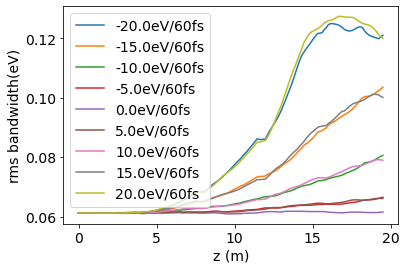

In [115]:
count = 0
chirplist = np.linspace(-20, 20, 9)
for rec in records[6:15]:
    chirp = chirplist[count]
    srms_list = []
    fwhm_list = []
    for z in zlist:
        hw0, sl,pl = get_spectra(z,rec) 
        low = 9831
        high = 9833
        sl2 = sl[(sl < high) & (sl > low)]
        pl = pl[(sl < high) & (sl > low)]
        
        norm_a = pl / np.sum(pl)
        mean_a = np.sum(sl2*norm_a)
     
        m2_a = np.sum(np.multiply(sl2 ** 2, norm_a))

        var_a = m2_a - mean_a ** 2
        

        
        srms_list.append(np.sqrt(var_a))
        width = fwhm(pl)*np.mean(np.diff(sl))
        fwhm_list.append(width[0]) 

    plt.plot(zlist, fwhm_list, label = str(chirp) + 'eV/60fs')
    count += 1
plt.legend()
plt.xlabel('z (m)')
plt.ylabel('rms bandwidth(eV)')
plt.show()

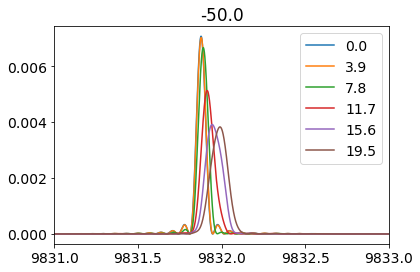

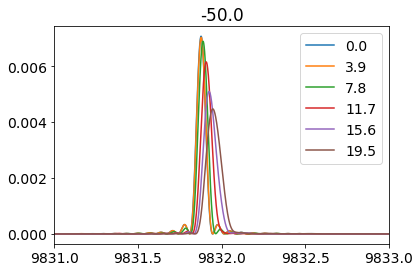

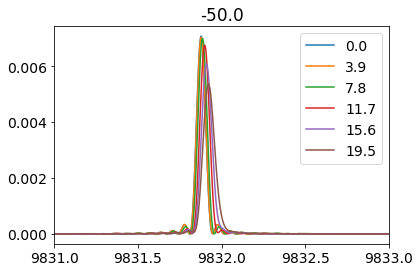

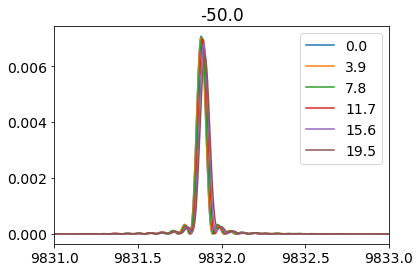

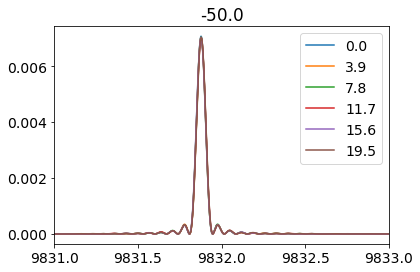

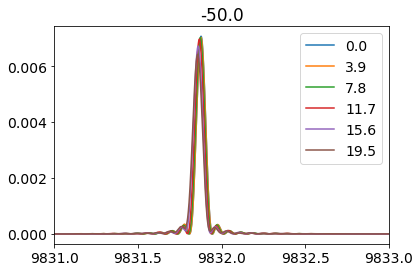

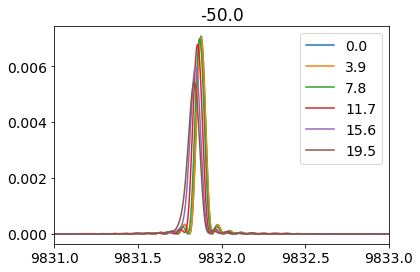

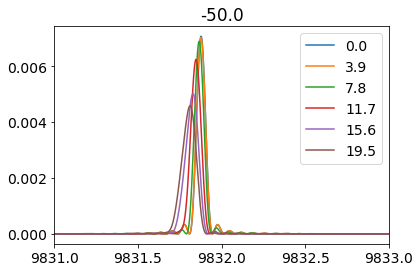

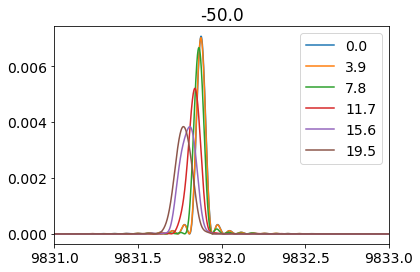

In [114]:
count = 0
for rec in records[6:15]:
    chirp = chirplist[count]
    scenter_list = []
    plt.figure()
    plt.title(str(chirp))
    for z in zlist[::30]:
        hw0, sl,pl = get_spectra(z,rec) 
        pl /= np.sum(pl)
        #sl -= sl[np.argmax(pl)]
        plt.plot(sl, pl, label = str(z))
    plt.xlim([9831,9833])
    plt.legend()
    plt.show()

In [1]:
import numpy as np

In [2]:
6.58*2*np.pi*0.411*0.1

1.699212068103033

In [3]:
1.7/0.06

28.333333333333332

In [4]:
1.7/0.145

11.724137931034484

In [1]:
import numpy as np

In [3]:
2*np.log(2)/np.pi*2*np.pi*6.582119569e-16

1.824951048544317e-15

In [4]:
2*np.log(2)/np.pi*2*np.pi*6.582119569e-16/0.06

3.041585080907195e-14

In [8]:
4*np.log(2)*6.582119569e-1

1.824951048544317